In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from pyloricfitness import *
from CTRNNclass import *
from HPevolution import *
from acceptance import *
from CTRNNgenomesamp import *

In [11]:
sol1 = np.array([ 14.82024187,  10.61253584,-12.15141158,  -4.61967513,-15.81543225,  15.62745189,  14.71262429,   2.0523492 , 1.86045721, -10.25813196,  -0.29218389,  -2.47607644, 1.13091869,   4.00518322,   3.57617411])

solcoevolved = np.array([-1.66277628e+00,  6.08372573e+00,  2.02550211e-02,  9.42733663e-01,
        8.46697321e+00,  4.99193437e+00, -5.60691553e+00, -6.66479592e+00,
        5.06919151e+00,  3.36623523e+00, -3.18997036e+00, -4.84189892e+00,
        7.37470557e+00,  9.79376709e+00,  2.56164698e+00])

In [12]:
def neurongenomesamp2D(dim1,dim2,dim1lb,dim2lb,dim1ub,dim2ub,spacing,sol):
    '''dim1 and dim2 are the indecies within the CTRNN genome of the dimensions of your slice,
    lbs and ubs are the range over each dimension to sample, spacing is how far apart the points are,
    sol is the solution on which to center your slice'''
    ypts = int((dim1ub-dim1lb)/spacing)  #x and y based on the axes of the graph (x for column #, y for row #)
    xpts = int((dim2ub-dim2lb)/spacing)
    samp = np.zeros((ypts,xpts,len(sol)))
    neurongenome = np.copy(sol1)
    neurongenome[dim1] = dim1lb 
    for i in range(ypts):
        neurongenome[dim2] = dim2lb 
        for j in range(xpts):
            samp[i,j] = neurongenome
            neurongenome[dim2] += spacing       #and increment it with each loop
        neurongenome[dim1] += spacing
    return samp


In [13]:
#dim1lb = 6
#dim1ub = 16
#dim2lb = 6
#dim2ub = 16
#spacing = .5 #(must go evenly into both the interval widths)

dim1lb = -5
dim1ub = 5
dim2lb = 0
dim2ub = 10
spacing = .5 #(must go evenly into both the interval widths)

dim1 = 0 #index of par on x axis
dim2 = 1 #index par on y axis

specificparameters = np.ones(len(solcoevolved))
#specificparameters = np.zeros(len(sol1))
#specificparameters[dim1] = 1 #making it so that HP can only change pars in the two dimensions we are visualizing
#specificparameters[dim2] = 1

acceptancegrid = np.zeros((int((dim1ub-dim1lb)/spacing),int((dim2ub-dim2lb)/spacing)))
fitnessgrid = np.zeros((int((dim1ub-dim1lb)/spacing),int((dim2ub-dim2lb)/spacing)))    #pyloric fitness without HP

HPgenomegeneric = np.array([.25,.25,.25,.75,.75,.75,40,20,1])

HPgenomecoevolved = np.array([ 0.35847261 , 0.20945884 , 0.34201794 , 0.36847261 , 0.21945883,  0.82836489,
 39.9910632 , 19.0137781,  40.])

neurongenomesamp = neurongenomesamp2D(dim1,dim2,dim1lb,dim2lb,dim1ub,dim2ub,spacing,solcoevolved) #evenly spaced grid of CTRNN genomes

In [14]:
calcfitnessfirsttime = 1

for i in range(len(neurongenomesamp)):
    for j in range(len(neurongenomesamp[0])):
        acceptancegrid[i,j] = acceptance(HPgenomecoevolved, np.copy(neurongenomesamp[i,j]), specificparameters)
        if calcfitnessfirsttime: #if you're going through this loop for the first time, need to calculate fitness at every pt
            fitnessgrid[i,j] = pyloriclike(neurongenomesamp[i,j],specificpars=specificparameters)         

0


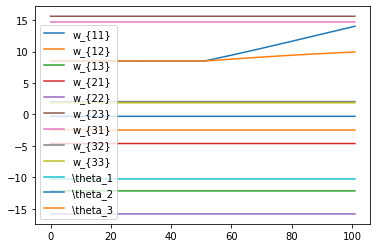

1


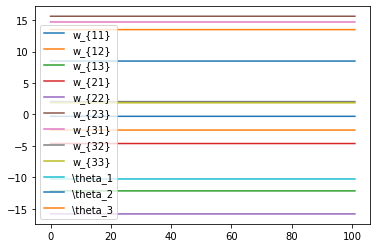

0


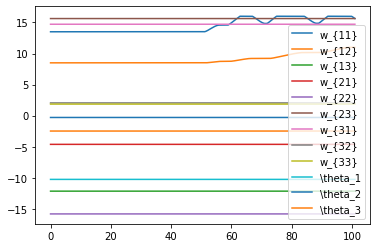

0


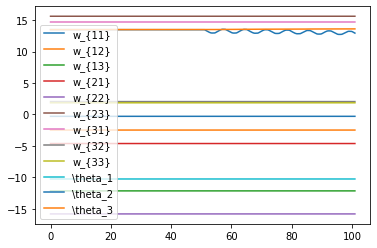

In [6]:
#collect parameter trajectories from various IC's to plot

#same settings as the acceptance function
dt = .025
transientdur = 50 #seconds passed without HP
transientlen = int(transientdur/dt) #timesteps passed without HP
rundur = 50 #seconds passed where you test whether HP would be turned on or not
runlen = int(rundur/dt) #timesteps passed where HPturnedon
initial_states = np.array([[10.,10.,10.],[0.,10.,10.],[10.,0.,10.],[10.,10.,0.]])
slidingwindowdur = HPgenomegeneric[-1]

pts=[[5,5],[5,15],[15,5],[15,15]]
trajectories = np.zeros((len(pts),2,int((transientdur+testdur+slidingwindowdur)/dt)))
idx = 0

for i in range(20):
    for j in range(20):
        if [i,j] in pts:
            IC = np.copy(neurongenomesamp[i,j]) #neurongenome form
            C = CTRNN(3,dt,transientdur+testdur+slidingwindowdur,HPgenomegeneric,IC,specificparameters)
            print(acceptance(HPgenomegeneric,IC,specificparameters))
            C.initializeState(initial_states[0])
            C.resetStepcount()
            for t1 in range(transientlen+int(HPgenomegeneric[-1])+39):        #run the CTRNN for the transient and the length of the slidign window without checking HP 
                C.ctrnnstep(0)
            for t2 in range(runlen):             #run for the actual running period, checking HP every step
                C.ctrnnstep(1) #pars actually changing
            C.plotparams()
            plt.show()
            trajectories[idx,0] = C.weight_record[0,0,:] #specific to w_11
            trajectories[idx,1] = C.weight_record[0,1,:] #specific to w_12
            idx+=1

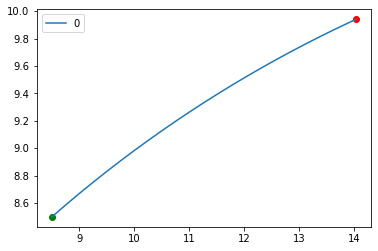

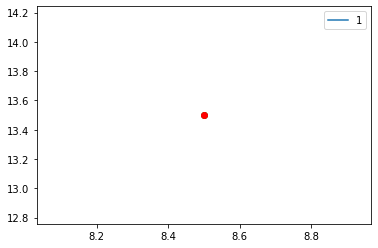

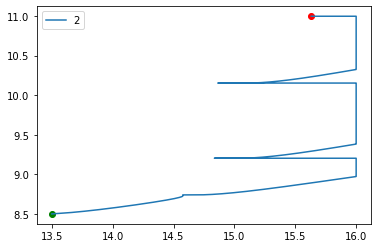

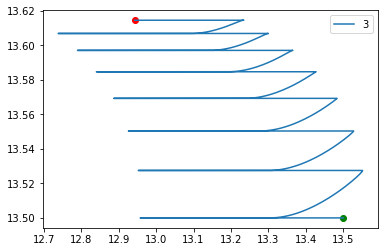

In [62]:
for i in range(len(pts)):
    plt.scatter(trajectories[i,0,0],trajectories[i,1,0],color='green')
    plt.scatter(trajectories[i,0,-1],trajectories[i,1,-1],color='red')
    plt.plot(trajectories[i,0],trajectories[i,1])
    plt.show()

In [1]:
#colormap graph the fitness grid

cmap = cm.summer
fig, ax2 = plt.subplots(ncols=1)

norm = colors.BoundaryNorm((0,.3,.6,.61,.62,.63,.64,.65,.66,.67,.68,.69,.7,.8,.9,1), ncolors=cmap.N, clip=True) #scaled to show extra pyloricness
#norm = colors.BoundaryNorm((0,.0501,.101,.1501,.201,.2501,.301,1), ncolors=cmap.N, clip=True) #scaled to show oscillation and ordering


pc = ax2.pcolormesh(fitnessgrid, norm=norm, cmap=cmap)
fig.colorbar(pc, ax=ax2)
fig.set_figheight(10)
fig.set_figwidth(17)
ax2.set_title('Pyloric Fitness')
ax2.set_ylabel(r'$w_{11}$')
ax2.set_xlabel(r'$w_{12}$')
xticks = np.arange(0,(int((dim2ub-dim2lb)/spacing))+1)
ax2.set_xticks(xticks)
xticklabels = np.round(np.arange(dim2lb,dim2ub+0.0001,spacing),3)
ax2.set_xticklabels(xticklabels,rotation = 90)
ax2.tick_params(axis='both', which='major', labelsize=7)
yticks = np.arange(0,(int((dim1ub-dim1lb)/spacing))+1)
ax2.set_yticks(yticks)
yticklabels = np.round(np.arange(dim1lb,dim1ub+0.0001,spacing),3)
ax2.set_yticklabels(yticklabels)

plt.show()

NameError: name 'cm' is not defined

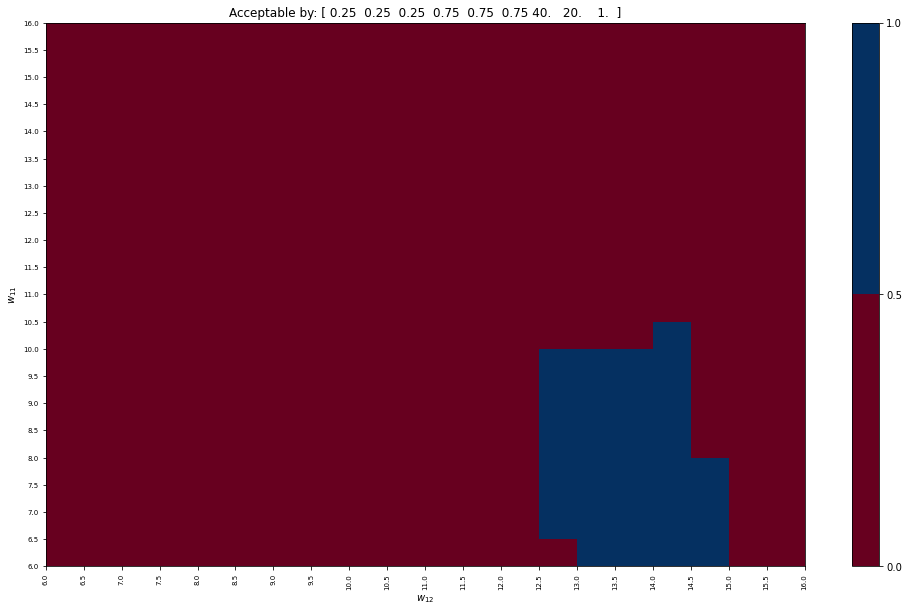

In [17]:
#colormap graph the realm of acceptability grid

cmap = cm.RdBu

fig, ax2 = plt.subplots(ncols=1,figsize=(17,10))

norm = colors.BoundaryNorm((0,.5,1), ncolors=cmap.N, clip=True)

pc = ax2.pcolormesh(acceptancegrid, norm=norm, cmap=cmap)
fig.colorbar(pc, ax=ax2)
ax2.set_title('Acceptable by: %s'%HPgenomegeneric)
ax2.set_ylabel(r'$w_{11}$')
ax2.set_xlabel(r'$w_{12}$')
xticks = np.arange(0,(int((dim2ub-dim2lb)/spacing))+1)
ax2.set_xticks(xticks)
xticklabels = np.round(np.arange(dim2lb,dim2ub+0.0001,spacing),3)
ax2.set_xticklabels(xticklabels,rotation = 90)
ax2.tick_params(axis='both', which='major', labelsize=7)
yticks = np.arange(0,(int((dim1ub-dim1lb)/spacing))+1)
ax2.set_yticks(yticks)
yticklabels = np.round(np.arange(dim1lb,dim1ub+0.0001,spacing),3)
ax2.set_yticklabels(yticklabels)
plt.show()

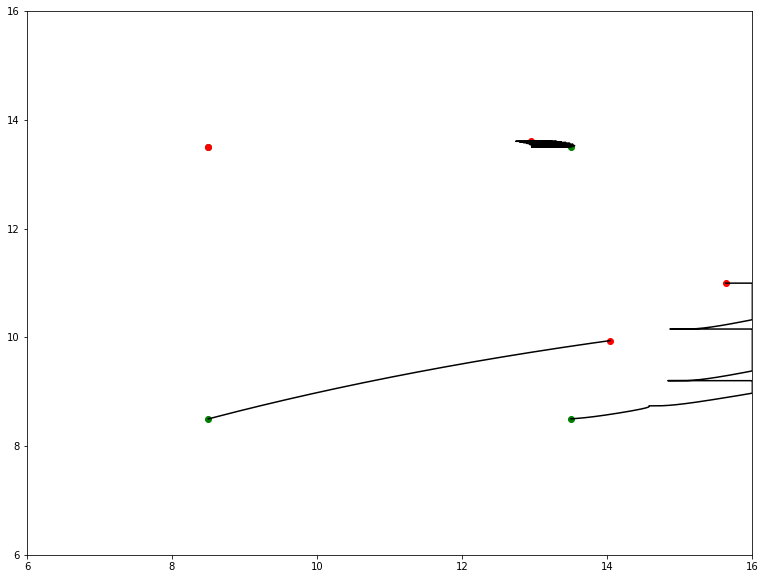

In [20]:
fig, ax = plt.subplots(figsize=(13,10))

for i in range(len(pts)):
    ax.scatter(trajectories[i,0,0],trajectories[i,1,0],color='green')
    ax.scatter(trajectories[i,0,-1],trajectories[i,1,-1],color='red')
    ax.plot(trajectories[i,0],trajectories[i,1],color='black')
    
plt.xlim([6,16])
plt.ylim([6,16])
plt.show()